[← Previous: Topic Modeling with NMF ](03_topic_modeling_byNMF.ipynb)
# **Unsupervised Topic Modeling with BERTopic**

**Goal:** Using BERTopic model to discover topic in general Reddit communities.

---

## Table of Contents

- [1. Imports & Environment Settings](#1-imports--environment-settings)
- [2. Helper Functions](#2-helper-functions)
- [3. Data Ingestion & Preprocessing](#3-data-ingestion--preprocessing)
- [4. Comparing Text Processing Methods](#4-comparing-text-processing-methods)
- [5. Comparing Different Parameter Sets](#5-comparing-different-parameter-sets)
- [6. Final Model Fitting and Output](#6-final-model-fitting--output)
- [7. Word Could and Topic Distribution](#7-word-could-and-topic-distribution)
- [8. Conclusion and Future Improvement](#8-conclusion-and-future-improvements)

[Next: Labeled Dataset Comparison →](05_dataset_comparison_analysis.ipynb)


In [ ]:
# %pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 24.3 MB/s  0:00:00 26.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 29.0 MB/s  0:00:00.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "/Users/shutinghe/.pyenv/versions/garden_env/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
        File "/Users/shutinghe/.pyenv/versions/garden_env/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**ho

## **1. Imports & Environment Settings**

**Purpose**: Initialize required libraries, set reproducible seeds and environment.

In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from pathlib import Path
import sys
sys.path.append("../src") 

import text_processing_functions as tp
from typing import Sequence, Dict, Any, Tuple, List, Optional
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import time

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from umap import UMAP

# set environment variable to avoid tokenizer parallelism warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import random
import torch
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram

from collections import Counter


## **2. Helper Functions**

**Purpose**: Provides utilities for text processing and model evaluation.

In [ ]:
def text_process_with_light_stop_words(texts):
    """
    Generate tokens that applied light cutomized stop words for text processing method testing
    """
    stop_words_light = {'<cmt>', '[deleted]', 'amp', 'http', 'https', 'edit',
                'deleted', 'thing', 'stuff', 'really', 'just', 'like',
                'thanks', 'lol', 'im', 'dont', 'ive', 'youre', 'thats'}
    tokens = [
        w
        for w in texts
        if w not in stop_words_light
        and len(w) > 1
        and " " not in w
    ]
    return tokens

def evaluate_bertopic(
    model: BERTopic,
    docs_tokens: Sequence[Sequence[str]],
    doc_topics: Sequence[int],
    *,
    top_n_words: int = 10,
    topic_probs: Optional[Any] = None,
    purity_threshold: float = 0.40,
) -> Dict[str, Any]:
    """
    Compute BERTopic evaluation metrics:
      • Topic Coherence (c_v) using gensim.
      • Outlier fraction (topic == -1).
      • Purity score (share of documents with confident assignment).
      • Mean cosine similarity between topic word-weight vectors.
      • Topic diversity (share of unique top words).

    Parameters
    ----------
    model :
        Fitted BERTopic instance.
    docs_tokens :
        Tokenized documents used to fit/evaluate the model.
    doc_topics :
        Topic assignment per document (the `topics` output from fit_transform).
    top_n_words :
        Number of top terms per topic to use for coherence and diversity.
    topic_probs :
        Optional document-topic probability matrix returned by BERTopic.
    purity_threshold :
        Probability threshold for counting a document as confidently assigned.

    Returns
    -------
    dict with keys:
        'coherence_cv', 'outlier_fraction', 'topic_diversity',
        'purity_score', 'mean_cosine_similarity', 'n_topics'
    """
    # Build gensim dictionary/corpus for coherence
    dictionary = Dictionary(docs_tokens)
    corpus = [dictionary.doc2bow(doc) for doc in docs_tokens]

    # Collect top words per topic (skip the outlier topic -1)
    topic_words: List[List[str]] = []
    topic_word_dicts: List[Dict[str, float]] = []
    topics_dict = model.get_topics()
    topic_info = model.get_topic_info()
    valid_topics = topic_info[topic_info["Topic"] != -1]["Topic"].tolist()

    for topic_id in valid_topics:
        words_weights = topics_dict.get(topic_id, [])[:top_n_words]
        if not words_weights:
            continue
        topic_words.append([word for word, _ in words_weights])
        topic_word_dicts.append({word: float(weight) for word, weight in words_weights})

    # Coherence (c_v)
    coherence_cv = float("nan")
    if topic_words:
        coherence_model = CoherenceModel(
            topics=topic_words,
            texts=docs_tokens,
            corpus=corpus,
            dictionary=dictionary,
            coherence="c_v",
        )
        coherence_cv = coherence_model.get_coherence()

    # Outlier fraction
    doc_topics_arr = np.asarray(doc_topics)
    outlier_fraction = float(np.mean(doc_topics_arr == -1))

    # Topic diversity: unique words divided by total words considered
    unique_words = len({word for words in topic_words for word in words})
    total_words = len(topic_words) * top_n_words
    topic_diversity = unique_words / total_words if total_words else float("nan")

    # Purity score based on available probabilities
    purity_score = float("nan")
    candidate_probs = topic_probs
    if candidate_probs is None:
        candidate_probs = getattr(model, "probabilities_", None)
    if candidate_probs is None and hasattr(model, "hdbscan_model"):
        candidate_probs = getattr(model.hdbscan_model, "probabilities_", None)

    if candidate_probs is not None:
        probs_array = np.asarray(candidate_probs)
        if probs_array.ndim == 2 and probs_array.size:
            probs_array = np.nan_to_num(probs_array, nan=0.0, posinf=0.0, neginf=0.0)
            row_sums = probs_array.sum(axis=1, keepdims=True)
            row_sums = np.maximum(row_sums, np.finfo(float).eps)
            normalized = probs_array / row_sums
            purity_score = float(np.mean(normalized.max(axis=1) >= purity_threshold))
        elif probs_array.ndim == 1 and probs_array.size:
            probs_array = np.nan_to_num(probs_array, nan=0.0, posinf=0.0, neginf=0.0)
            purity_score = float(np.mean(probs_array >= purity_threshold))

    # Mean cosine similarity across topic word-weight vectors
    mean_cosine_similarity = float("nan")
    if topic_word_dicts:
        vec = DictVectorizer(sparse=False)
        topic_matrix = vec.fit_transform(topic_word_dicts)
        if topic_matrix.shape[0] == 1:
            mean_cosine_similarity = 0.0
        elif topic_matrix.shape[0] > 1:
            norms = np.linalg.norm(topic_matrix, axis=1, keepdims=True)
            norms = np.maximum(norms, np.finfo(float).eps)
            normalized = topic_matrix / norms
            cosine_matrix = normalized @ normalized.T
            np.fill_diagonal(cosine_matrix, 0.0)
            mask = np.triu(np.ones_like(cosine_matrix, dtype=bool), k=1)
            mean_cosine_similarity = float(cosine_matrix[mask].mean())

    n_topics = len(valid_topics)

    return {
        "coherence_cv": coherence_cv,
        "outlier_fraction": outlier_fraction,
        "topic_diversity": topic_diversity,
        "purity_score": purity_score,
        "mean_cosine_similarity": mean_cosine_similarity,
        "n_topics": n_topics,
    }


def plot_bertopic_similarity_heatmap( model, merged_df=None, *, figsize=(10, 4), cmap="Blues", max_topics=30):
    """
    Visualize cosine similarities between BERTopic topics with a heatmap
    (and matching dendrogram) using the model trained with the best parameters.
    """

    topic_counts = merged_df["Topic"].value_counts()
    topic_names = merged_df['Name'].value_counts()
    display(topic_names)
    ordered_ids = [t for t, _ in topic_counts.sort_values(ascending=False).items()]

    if len(ordered_ids) > max_topics:
        ordered_ids = ordered_ids[:max_topics]

    embeddings = getattr(model, "topic_embeddings_", None)

    topic_vectors = np.asarray(embeddings)[ordered_ids]
    norms = np.linalg.norm(topic_vectors, axis=1, keepdims=True)
    norms = np.maximum(norms, np.finfo(float).eps)
    topic_vectors = topic_vectors / norms

    similarity = cosine_similarity(topic_vectors)
    np.fill_diagonal(similarity, 1.0)

    distance = 1 - similarity
    np.fill_diagonal(distance, 0)
    condensed = distance[np.triu_indices_from(distance, k=1)]
    linkage_matrix = linkage(condensed, method="ward")

    fig, (ax_heatmap, ax_dendrogram) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={"width_ratios": [2, 1]})

    sns.heatmap(
        similarity,
        cmap=cmap,
        vmin=0,
        vmax=1,
        square=True,
        cbar_kws={"label": "Cosine Similarity"},
        xticklabels=ordered_ids,
        yticklabels=ordered_ids,
        ax=ax_heatmap,
        linewidths=0.4,
        linecolor="#e0e0e0",
    )
    ax_heatmap.set_title("BERTopic Topic Similarity Matrix")
    ax_heatmap.set_xlabel("Topic ID")
    ax_heatmap.set_ylabel("Topic ID")

    dendrogram(
        linkage_matrix,
        labels=[f"T{tid}" for tid in ordered_ids],
        orientation="top",
        leaf_font_size=10,
        ax=ax_dendrogram,
        above_threshold_color="#374151",
    )
    ax_dendrogram.set_title("Topic Hierarchy (Ward linkage)")
    ax_dendrogram.set_xlabel("Distance")
    ax_dendrogram.set_ylabel("Topic")

    plt.tight_layout()
    return fig, (ax_heatmap, ax_dendrogram)

def plot_top_words_per_topic(
    df,
    top_n=20,
    cols=3,
    figsize_per_plot=(4, 3),
    color="#1f77b4",
):
    """Bar charts of the top-N tokens for each BERTopic topic."""
    df_topics = df['Name'].unique().tolist()

    topic_top_words = {}
    for topic in df_topics:
        full_text = " ".join(df[df['Name'] == topic]["text_all_processed"].dropna().astype(str))
        tokens = full_text.split()
        freqs = Counter(tokens) 
        top_words = freqs.most_common(top_n)
        topic_top_words[topic] = top_words       
    

    rows = int(np.ceil(len(topic_top_words) / cols))
    fig, axes = plt.subplots(
        rows,
        cols,
        figsize=(figsize_per_plot[0] * cols, figsize_per_plot[1] * rows),
        squeeze=False,
    )

    for ax, topic in zip(axes.flat, df_topics):
        words = topic_top_words.get(topic, [])
        if not words:
            ax.set_visible(False)
            continue

        top_words = words[:top_n]
        tokens, scores = zip(*top_words)
        ax.barh(range(len(tokens)), scores[::1], color=color)
        ax.set_yticks(range(len(tokens)))
        ax.set_yticklabels(tokens[::-1])
        ax.invert_yaxis()
        ax.set_title(f"Topic {topic}")
        ax.set_xlabel("Weight")

    for ax in axes.flat[len(df_topics):]:
        ax.set_visible(False)

    fig.tight_layout()
    return fig

## **3. Data Ingestion & Preprocessing**

**Purpose**: Load the Reddit dataset, generate stop words and apply process text function imported from `src/text_processing_functions.py` to process Reddit posts.

- Create a copy of the raw dataset.
- Posts processed with the default stop_words saved as `text_all_processed`
- Posts processed with TF-IDF-based stop words are saved as `text_all_processed_tfidf`
- Posts processed with lightly customized stop words are saved as `text_all_processed_light`

In [4]:
path = Path("../data/processed/reddit_anxiety_v1.parquet")
raw_data = pd.read_parquet(path)

# Generate two sets of stopwords: base + auto-detected
print("Generating stopwords...")
_, stopwords = tp.process_text(
    "\n\n".join(raw_data["text_all"].astype(str)),
    return_stopwords=True,
)

_, auto_stop, stopwords_tfidf = tp.process_text_tfidf(
    "\n\n".join(raw_data["text_all"].astype(str)),
    return_stopwords=True,
)

start_time = time.time()
print("Preprocessing text...")
df = raw_data.copy()

df["text_all_processed"] = (
    df["text_all"]
    .fillna("")
    .apply(lambda doc: tp.process_text(doc, extra_stopwords=stopwords))
)
df["text_all_processed_tfidf"] = (
    df["text_all"]
    .fillna("")
    .apply(lambda doc: tp.process_text_tfidf(doc, extra_stopwords=stopwords))
)

df["text_all_processed_light"] = (
    df["text_all"]
    .fillna("")
    .apply(lambda doc: text_process_with_light_stop_words(doc.split())) )

print(f"Data preprocessing time: {time.time() - start_time:.2f} seconds")
print(f"Loaded {len(df):,} submissions")
print(df['subreddit'].value_counts())
df.head(5)

Generating stopwords...
Preprocessing text...
Data preprocessing time: 68.56 seconds
Loaded 6,283 submissions
subreddit
unpopularopinion    976
Anxiety             968
TrueOffMyChest      914
economy             893
mentalhealth        788
OpenAI              768
GetMotivated        678
HealthAnxiety       298
Name: count, dtype: int64


,post_id,subreddit,created_ts,title,selftext,score,num_comments,upvote_ratio,over_18,removed_by_category,...,title_clean,selftext_clean,comments_concat,comment_count,text_main,text_all,comments_missing,text_all_processed,text_all_processed_tfidf,text_all_processed_light
0,1fqk5d2,HealthAnxiety,1727431124,How Do You Calm Your Mind During Health Anxiet...,I’ve been struggling with health anxiety latel...,79,63,0.98,False,<NA>,...,how do you calm your mind during health anxiet...,i’ve been struggling with health anxiety latel...,i try to think back on all the times i've spir...,3,how do you calm your mind during health anxiet...,how do you calm your mind during health anxiet...,0,"[calm, mind, dure, health, anxieti, spiral, st...","[calm, dure, anxieti, spiral, struggl, anxieti...","[how, do, you, calm, your, mind, during, healt..."
1,1fryfai,HealthAnxiety,1727592641,Exposure therapy,Has anyone managed to overcome health anxiety ...,12,12,0.94,False,<NA>,...,exposure therapy,has anyone managed to overcome health anxiety ...,starting it now! just made a fear ladder with ...,3,exposure therapy\n\nhas anyone managed to over...,exposure therapy\n\nhas anyone managed to over...,0,"[exposur, therapi, manag, overcom, health, anx...","[exposur, therapi, manag, overcom, health, anx...","[exposure, therapy, has, anyone, managed, to, ..."
2,1frykue,HealthAnxiety,1727593277,embarrassed to seek medical attention?,"Hi, i wanted to ask if anyone else feels sympt...",68,25,1.00,False,<NA>,...,embarrassed to seek medical attention?,"hi, i wanted to ask if anyone else feels sympt...",i always tell my doctor that i struggle with a...,3,"embarrassed to seek medical attention?\n\nhi, ...","embarrassed to seek medical attention?\n\nhi, ...",0,"[embarrass, seek, medic, attent, hi, els, symp...","[embarrass, seek, medic, attent, hi, els, symp...","[embarrassed, to, seek, medical, attention?, h..."
3,1fso9mv,HealthAnxiety,1727674066,"When you feel most bodily anxious, what works ...",I have a lot of bodily anxieties and am so afr...,31,60,0.98,False,<NA>,...,"when you feel most bodily anxious, what works ...",i have a lot of bodily anxieties and am so afr...,"this is embarrassing to admit, but i carry aro...",3,"when you feel most bodily anxious, what works ...","when you feel most bodily anxious, what works ...",0,"[bodili, anxious, semi, consist, lot, bodili, ...","[bodili, semi, consist, lot, bodili, anxieti, ...","[when, you, feel, most, bodily, anxious,, what..."
4,1ftczi7,HealthAnxiety,1727748023,Daily Positivity & HA Journey Progress Updates...,"**The megathread for vents, rants, worries, fi...",1,22,1.00,False,<NA>,...,daily positivity & ha journey progress updates...,"**the megathread for vents, rants, worries, fi...",despite being on edge all weekend knowing my b...,3,daily positivity & ha journey progress updates...,daily positivity & ha journey progress updates...,0,"[daili, posit, ha, journey, progress, updat, m...","[daili, posit, updat, octob, vent, rant, worri...","[daily, positivity, ha, journey, progress, upd..."


## **4. Comparing Text Processing Methods**

**Purpose**: Compare four different text processing methods using coherence, outlier fraction, topic diversity, and the number of topics as evaluation metrics to select the method that offers the best performance.

In [5]:
# comparing different text processing methods
start_time = time.time()

comparing_dict = {
    "not using Text Processing": df["text_all"].fillna("").astype(str).tolist(),
    "using Light Stop Words": df["text_all_processed_light"].apply(lambda toks: " ".join(toks)).tolist(),
    "using Text Processing": df["text_all_processed"].apply(lambda toks: " ".join(toks)).tolist(),
    "using Text Processing with TF-IDF": df["text_all_processed_tfidf"].apply(lambda toks: " ".join(toks)).tolist(),
}
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") 
text_process_compare = pd.DataFrame.from_dict(comparing_dict)
metrics_list = []
for desc, docs in comparing_dict.items():
    print(f"--- Processing {desc} ---")
    topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=UMAP(random_state=42),
    hdbscan_model=HDBSCAN(min_cluster_size=15),
    vectorizer_model=CountVectorizer(),
    ctfidf_model=ClassTfidfTransformer()
    )
    topics, probs = topic_model.fit_transform(docs)
    docs_tokens = [doc.split() for doc in docs]    
    metrics = evaluate_bertopic(topic_model, docs_tokens, topics, top_n_words=10, topic_probs=probs)
    metrics_list.append((desc, metrics))

metrics_df = pd.DataFrame(
    [ {"description": desc, **metrics} for desc, metrics in metrics_list ]
)
print(f"Data preprocessing time: {time.time() - start_time:.2f} seconds")
metrics_df

--- Processing not using Text Processing ---


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


--- Processing using Light Stop Words ---
--- Processing using Text Processing ---
--- Processing using Text Processing with TF-IDF ---
Data preprocessing time: 469.93 seconds


,description,coherence_cv,outlier_fraction,topic_diversity,purity_score,mean_cosine_similarity,n_topics
0,not using Text Processing,0.465186,0.135763,0.496296,0.850390,0.221654,27
1,using Light Stop Words,0.478961,0.129078,0.575862,0.861213,0.177018,29
2,using Text Processing,0.588065,0.319115,0.850000,0.671495,0.012276,30
3,using Text Processing with TF-IDF,0.567008,0.010664,0.950000,0.981060,0.009057,4


### Comparing 4 text preprocessing methods for BERTopic
**Metrics Explanation**
- **coherence_cv**: Measuring how well the top words in each topic "make sense together". Higher the value means more meaningful topics.
- **outlier_fraction**: Measuring the percentage of posts that didn't fit into any topic (HDBSCAN marked them as -1). Lower the value means better coverage.
- **topic_diversity**: Measuring how distinct the top topic words are from each other (less duplication). Higher the value means broader, less repetitive topics.
- **purity_score**: Measuring alignment with known labels.
- **mean_cosine_similarity**: Measuring the overlap between topics.

**Not using Text Process**
- Topics read loosely (coherence ≈0.47); 14% of posts fall outside any topic; topics reuse many of the same words (diversity ≈0.50) with higher confidence in topic clustering but worse topic similarity ; 27 topics total.

**Using Light Stop Words**
- Small coherence bump (≈0.48) and slightly fewer outliers (13%); topics are a bit more distinct (diversity ≈0.58) with higher confidence in topic clustering and relatively lower similarity; 29 topics.

**Using Text Process**
- Topics are much clearer (coherence ≈0.59), lower topic similarity (mean_cosine_similarity 0.012)  and vocabulary is varied (diversity ≈0.85) with 30 topics, one‑third of documents don’t land in a topic (outlier_fraction ≈0.32) and topic clustering are less confident (purity_score 0.67). However, it strikes the best balance across the metrics while retaining the most topics, so we use this configuration as our baseline.
- ✅ Recommended as baseline for improvement

**Using Text Processing with TF-IDF**
- Keeps nearly every document in a topic (outlier_fraction ≈0.01), topics are very distinct (diversity ≈0.95) with confident topic clustering (purity_score 0.98) and lowest topic similarity (mean_cosine_similarity 0.009). Yet coherence is slightly lower than the fully processed run and the model collapses to only 4 topics.


### Conclusion
- Using **Text Processing** as baseline: It gives thestrong coherence and plenty of distinct topics (≈30). To tackle the higher outlier rate, tune the clustering later—relax HDBSCAN slightly or filter short/noisy docs—while keeping this richer preprocessing pipeline in place.

## **5. Comparing Different Parameter Sets**

**Purpose**: Compare five parameter sets using coherence, outlier fraction, topic diversity, and the number of topics as evaluation metrics to select the set that offers the best performance.

In [6]:
# comparing different parameters for BERTopic
start_time = time.time()
param_sets = [
    { 
        "name": "baseline_improvement",
        "umap_model": UMAP(n_neighbors=25, min_dist=0.1, random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=15, min_samples=12, prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.95),
        "ctfidf_model": ClassTfidfTransformer(),
        "top_n_words": 10
    },
    {
        "name": "balanced_baseline",
        "umap_model": UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine", random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=20, min_samples=10, cluster_selection_method="leaf", prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.95,
        stop_words=None),
        "ctfidf_model": ClassTfidfTransformer(reduce_frequent_words=True),
        "top_n_words": 15
    },
    {
        "name": "coherence_focused",
        "umap_model": UMAP(n_neighbors=30, n_components=5, min_dist=0.0, metric="cosine", random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=25, min_samples=25, cluster_selection_epsilon=0.1, cluster_selection_method="eom", prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 3), min_df=0.02,max_df=0.9,         max_features=20000, stop_words=None),
        "ctfidf_model": ClassTfidfTransformer(reduce_frequent_words=False),
        "top_n_words": 20
    },
    {
        "name": "diversity_focused",
        "umap_model": UMAP(n_neighbors=10, n_components=7, min_dist=0.1, metric="cosine", random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_method="eom", prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.98, max_features=5000,stop_words=None),
        "ctfidf_model": ClassTfidfTransformer(
            reduce_frequent_words=True,
            bm25_weighting=True,
        ),
        "top_n_words": 10,
    },
    {
        "name": "low_outlier",
        "umap_model": UMAP(n_neighbors=50, n_components=5, min_dist=0.0, metric="cosine", random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=30, min_samples=None, cluster_selection_method="leaf", prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.85, stop_words=None),
        "ctfidf_model": ClassTfidfTransformer(),
        "top_n_words": 10
    },

]

docs = df["text_all_processed"].apply(lambda toks: " ".join(toks)).tolist()

embeddings = embedding_model.encode(
    docs,
    convert_to_numpy=True,
    show_progress_bar=True,
    batch_size=32,
)

results = []

for params in param_sets:
    print(f"--- Processing {params['name']} ---")
    topic_model = BERTopic(
        embedding_model=embedding_model, 
        umap_model=params["umap_model"],
        hdbscan_model=params["hdbscan_model"],
        vectorizer_model=params["vectorizer_model"],
        ctfidf_model=params["ctfidf_model"],
        top_n_words=params["top_n_words"],
    )
    topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
    docs_tokens = [doc.split() for doc in docs]    
    metrics = evaluate_bertopic(topic_model, docs_tokens, topics, top_n_words=params["top_n_words"], topic_probs=probs)
    results.append({"name": params["name"], **metrics})


results_df = pd.DataFrame(results)
print(f"Data preprocessing time: {time.time() - start_time:.2f} seconds")
results_df

Batches:   0%|          | 0/197 [00:00<?, ?it/s]

--- Processing baseline_improvement ---
--- Processing balanced_baseline ---
--- Processing coherence_focused ---
--- Processing diversity_focused ---
--- Processing low_outlier ---
Data preprocessing time: 196.37 seconds


,name,coherence_cv,outlier_fraction,topic_diversity,purity_score,mean_cosine_similarity,n_topics
0,baseline_improvement,0.729794,0.049499,0.971429,0.947636,0.008760,7
1,balanced_baseline,0.525056,0.557536,0.941026,0.423365,0.003113,52
2,coherence_focused,0.452864,0.001592,1.000000,0.994907,0.000000,2
3,diversity_focused,0.485257,0.472863,0.878218,0.516791,0.002602,101
4,low_outlier,0.666536,0.664491,0.895000,0.330575,0.014675,20


### Comparing 5 parameter sets for BERTopic
**Baseline Improvement**
- Topics read very clearly (coherence ≈0.73), almost every post is assigned to a topic (outliers ≈5%), and topics use very different vocabularies (diversity ≈0.97); Confidence in topic clustering is high and topic similarity is low, but the model finds only 7 topics in total.
- ✅ Recommended as optimal parameter set for now.

**Balanced Baseline**
- Topics are moderately coherent (≈0.53), yet over half of the documents were left unassigned (outliers ≈56%); diversity stays high (≈0.94) with poor confidence in topic clustering; we get 52 topics.

**Coherence Focused**
- Coherence actually drops (≈0.45). Outliers are near zero (0.16%), and topics never reuse words (diversity = 1.0); Higher confidence in topic clustering and topic similarity is 0; but there are only 2 topics—too few for most analyses.

**Diversity Focused**
- Topics overlap more on wording (diversity ≈0.88) and coherence is low (≈0.49); nearly half the documents sit outside all topics (outliers ≈47%); Relatively poor confidence in topic clustering and slightly good topic similarity; Though we can get many topics (101).

**Low Outlier**
- Topic descriptions look good (coherence ≈0.67), but 66% of documents are still marked as outliers with very poor confidence in topic clustering and poor topic simialrity; vocabulary stays fairly distinct (≈0.90) with 20 topics.

### Conclusion
- We are targeting high coherence value, low outlier fraction, high topic diversity and more distinct number of topics. however, none of these parameter sets hits every target at once. Only **baseline_improvement** clears the coherence ≥0.6 bar while also keeping outliers low (≈5%) and diversity high (≈0.97), but it collapses to just 7 topics. **low_outlier** has acceptable coherence, yet more than 66% of documents are flagged as outliers, so it doesn’t meet the “lower outlier” requirement. Given that, **baseline_improvement** gives the best performance, hence recommend to use the parameter set of **baseline_improvement**.

## **6. Final Model Fitting & Output**

**Purpose**: Fit BERTopic model using optimized parameters, and output topic data table.

In [7]:
best_params = { 
        "name": "baseline_improvement",
        "umap_model": UMAP(n_neighbors=25, min_dist=0.1, random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=15, min_samples=12, prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.95),
        "ctfidf_model": ClassTfidfTransformer(),
        "top_n_words": 10
    }

topic_model = BERTopic(
    embedding_model=embedding_model, 
    umap_model=best_params["umap_model"],
    hdbscan_model=best_params["hdbscan_model"],
    vectorizer_model=best_params["vectorizer_model"],
    ctfidf_model=best_params["ctfidf_model"],
    top_n_words=best_params["top_n_words"],
)
topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
bertopic_df = topic_model.get_document_info(docs)
bertopic_df.head(5)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,calm mind dure health anxieti spiral struggl h...,0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False
1,exposur therapi manag overcom health anxieti o...,0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False
2,embarrass seek medic attent hi els symptom str...,0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False
3,bodili anxious semi consist lot bodili anxieti...,0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False
4,daili posit ha journey progress updat megathre...,-1,-1_life_job_posit_anxieti,"[life, job, posit, anxieti, thought, live, ple...",[daili posit ha journey progress updat megathr...,life - job - posit - anxieti - thought - live ...,0.0,False


In [8]:
# Merge topic data with original dataframe and save to parquet
bertopic_df['doc_ids'] = df.index
merged = df.reset_index()
merged = merged.merge(bertopic_df, how = 'left', left_on = 'index', right_on = 'doc_ids')
merged.drop(columns=['text_all_processed_tfidf', 'text_all_processed_light', 'Document', 'doc_ids'], inplace=True)
merged.to_parquet("../data/processed/reddit_topics_by_bertopic.parquet", index=False)
merged.head(2)


,index,post_id,subreddit,created_ts,title,selftext,score,num_comments,upvote_ratio,over_18,...,text_all,comments_missing,text_all_processed,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,0,1fqk5d2,HealthAnxiety,1727431124,How Do You Calm Your Mind During Health Anxiet...,I’ve been struggling with health anxiety latel...,79,63,0.98,False,...,how do you calm your mind during health anxiet...,0,"[calm, mind, dure, health, anxieti, spiral, st...",0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False
1,1,1fryfai,HealthAnxiety,1727592641,Exposure therapy,Has anyone managed to overcome health anxiety ...,12,12,0.94,False,...,exposure therapy\n\nhas anyone managed to over...,0,"[exposur, therapi, manag, overcom, health, anx...",0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False


## **7. Word Could and Topic Distribution**

**Purpose**: Check the topic patterns.

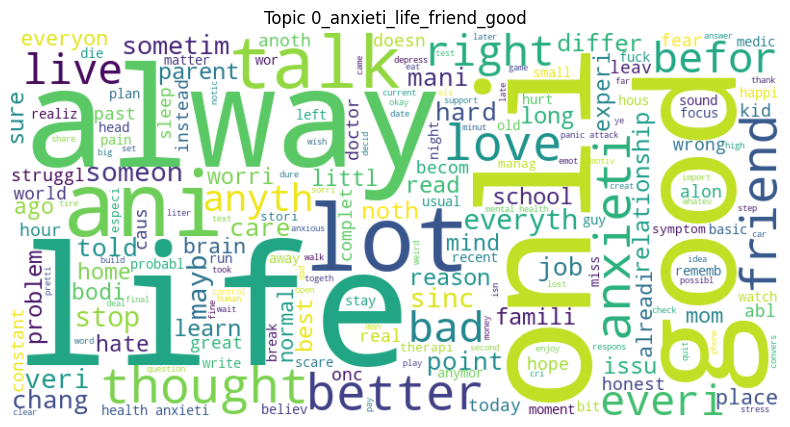

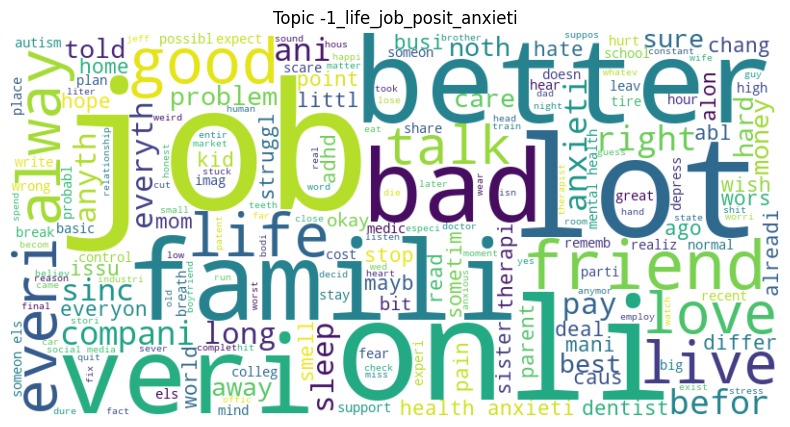

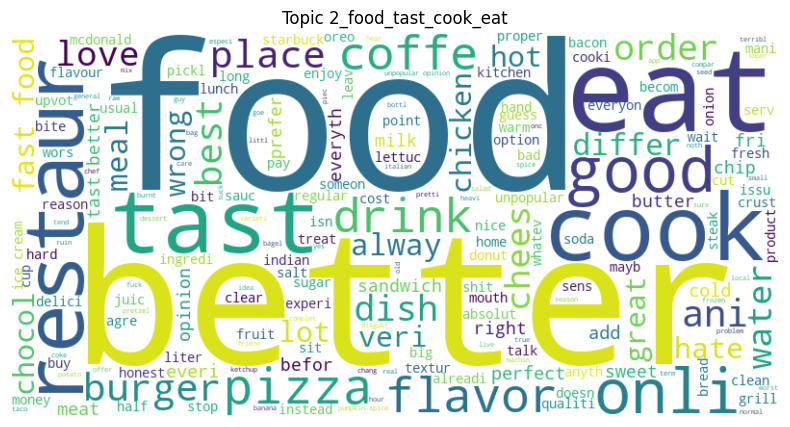

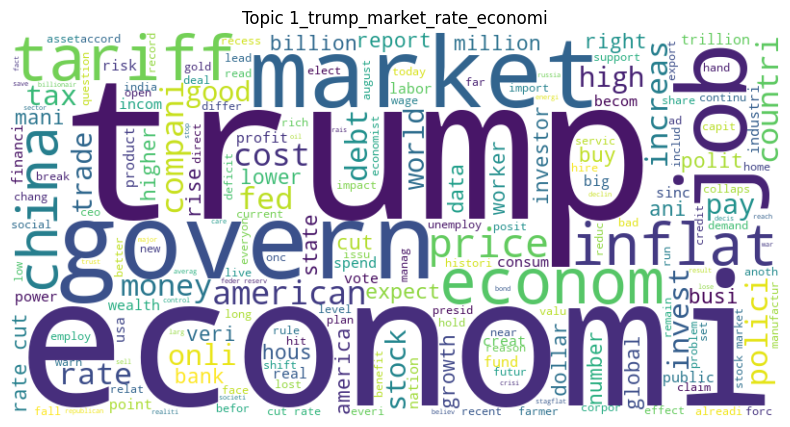

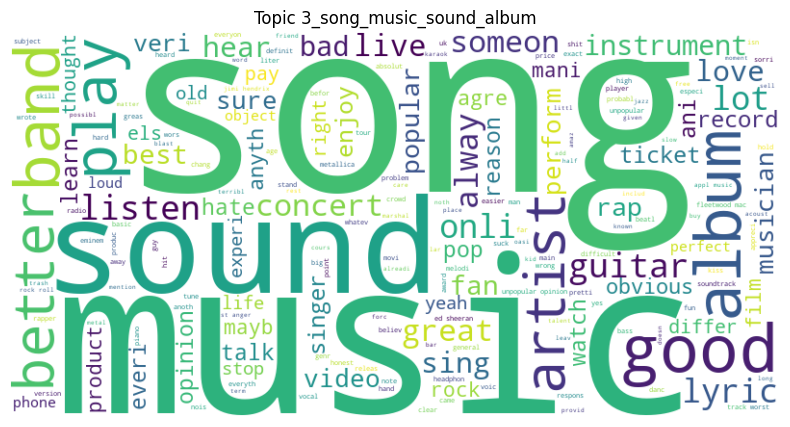

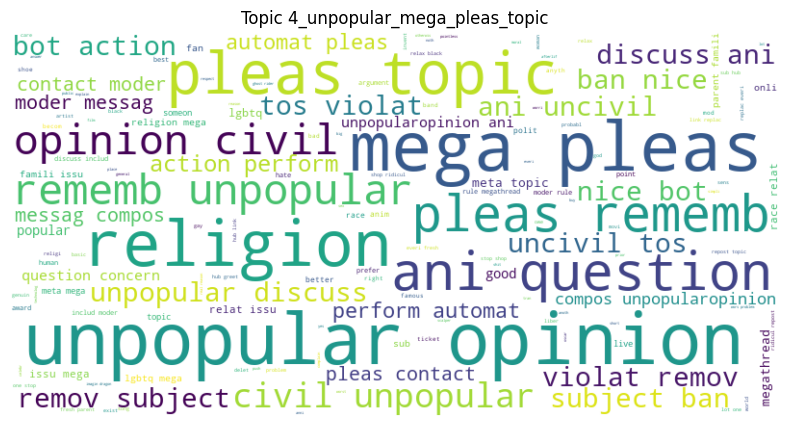

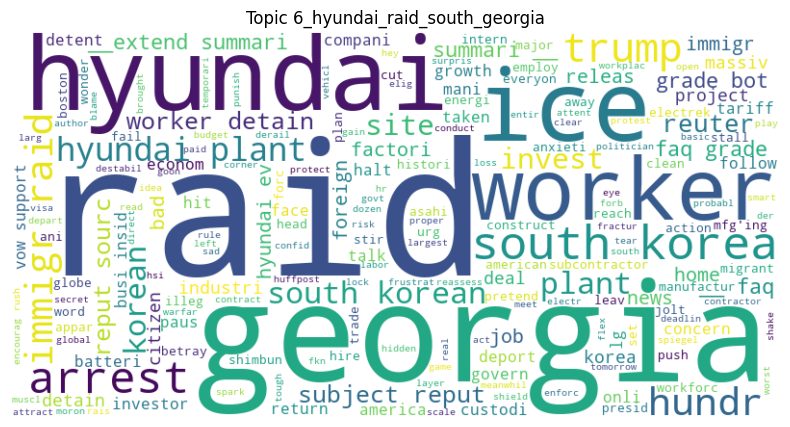

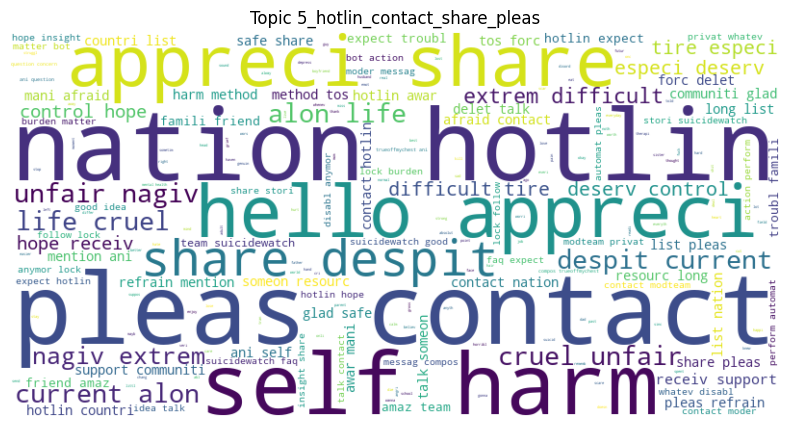

In [9]:
for topic in merged['Name'].unique():
    topic_docs = merged[merged['Name'] == topic]['text_all_processed']
    # Flatten list of tokens for all docs in this topic
    words = [word for tokens in topic_docs for word in tokens]
    text = ' '.join(words)
    if text.strip():  # Only plot if there are words
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic}")
        plt.show()

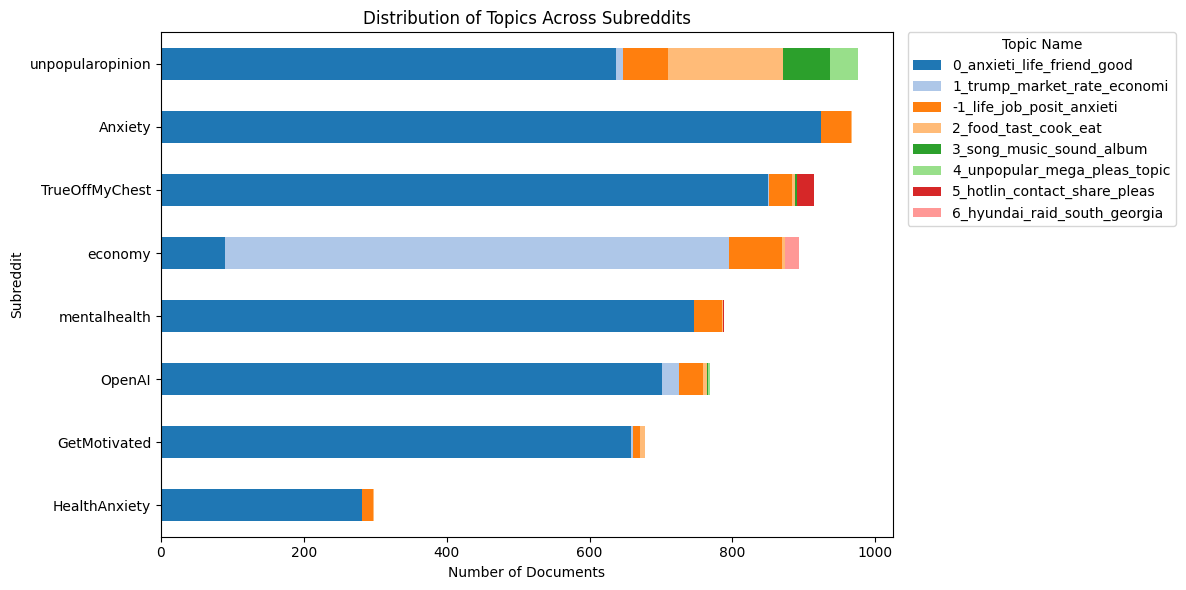

In [28]:
# Count topics across subreddits
topic_subreddit_counts = merged.groupby(['subreddit', 'Name']).size().unstack(fill_value=0)

# Order rows (subreddits) by total docs, and columns (topics) by total across subs
row_order = topic_subreddit_counts.sum(axis=1).sort_values(ascending=False).index
col_order = topic_subreddit_counts.sum(axis=0).sort_values(ascending=False).index
ordered = topic_subreddit_counts.loc[row_order, col_order]

colors = plt.get_cmap('tab20').colors

# Plot as a horizontal stacked bar chart
fig_h = max(6, 0.35 * len(ordered))  # scale height with number of subreddits
ax = ordered.plot(kind='barh', stacked=True, figsize=(12, fig_h), color=colors)

ax.set_xlabel('Number of Documents')
ax.set_ylabel('Subreddit')
ax.set_title('Distribution of Topics Across Subreddits')

# Put largest subreddit at the top
ax.invert_yaxis()

# Cleaner legend outside
ax.legend(title='Topic Name', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

Name
0_anxieti_life_friend_good      4887
1_trump_market_rate_economi      743
-1_life_job_posit_anxieti        311
2_food_tast_cook_eat             185
3_song_music_sound_album          71
4_unpopular_mega_pleas_topic      42
5_hotlin_contact_share_pleas      24
6_hyundai_raid_south_georgia      20
Name: count, dtype: int64

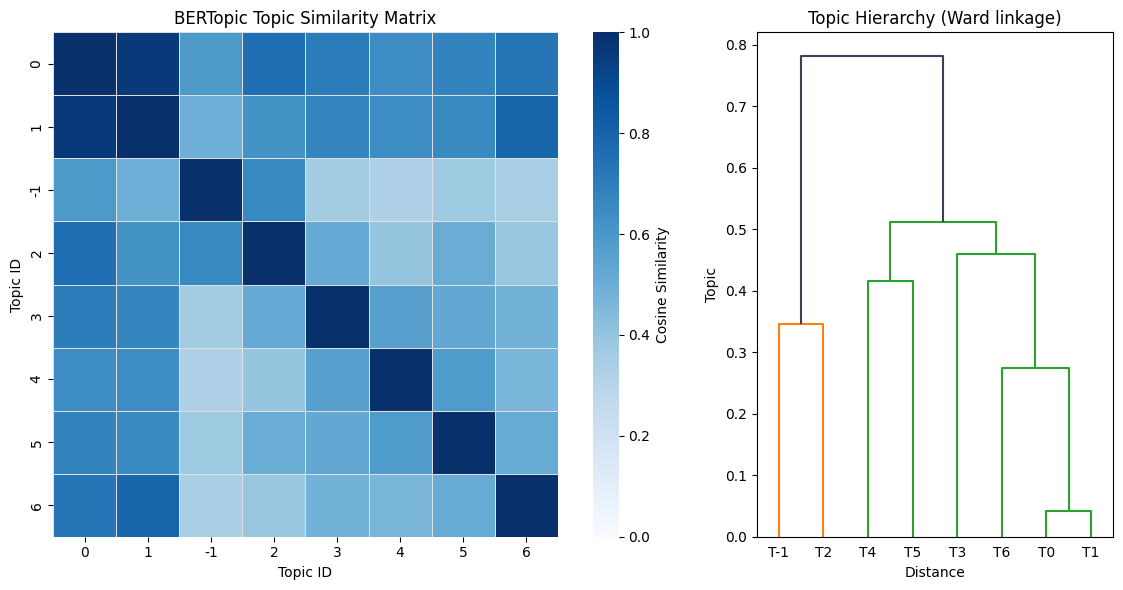

In [26]:
# plot topic similarity heatmap and dendrogram
fig, (ax_heatmap, ax_dendrogram) = plot_bertopic_similarity_heatmap(topic_model, merged, figsize=(12, 6), max_topics=30)

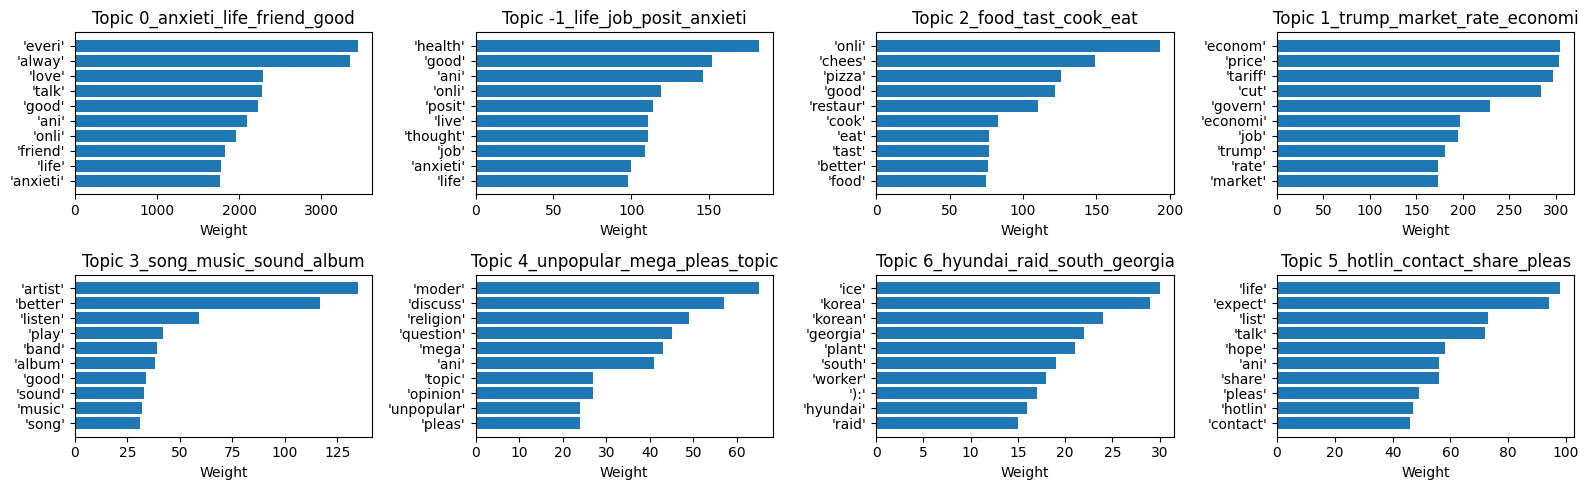

In [ ]:


fig = plot_top_words_per_topic(merged, top_n=10, cols=4, figsize_per_plot=(4, 2.5))
plt.show()

### Key Findings
- Word clouds show Topics 0, –1, and 2 sharing frequent terms like *onli*, *better*, and *good*, suggesting the model may have split one broad theme into several closely related clusters while other topics stay more distinct.
- Topic 0 dominates every subreddit in the distribution chart, hinting either at a genuinely pervasive theme or a cluster that’s absorbing too much of the corpus.
- The similarity heatmap flags Topics 0 and 1 as the closest pair.
- In the hierarchy plot, Topics –1 and 2 merge at a small distance (very similar), and several other topics sit closer together than expected—useful for spotting cluster redundancy.
- When inspecting the top-10 words per topic, Topics 0 and –1 overlap heavily while Topic 1’s vocabulary looks quite different, which contradicts the heatmap. That mismatch likely means BERTopic’s embeddings capture sentiment or contextual cues that simple word lists miss.

## **8. Conclusion and Future Improvements**

**Conclusion** \
After testing four text preprocessing methods and five hyperparameter configurations, we selected the **“baseline_improvement”** setting as the best-performing BERTopic model. It achieved stronger metric values but produced fewer distinct topics. Visualizations such as word clouds, bar charts, and cosine similarity plots showed that Topics 0 and 1 were highly similar, an overlap not easily visible through word-level inspection. The key takeaway is that BERTopic can capture deeper semantic and emotional relationships between posts, while simpler models (like baseline_improvement) may yield higher metrics but generate less meaningful, less diverse topics.

**Future Improvements** \
There are several potential issues can be addressed in the future:
- **Data Selection and Cleaning**: Our dataset contains a high proportion of anxiety-related subreddits (e.g., Anxiety, mentalhealth), which may limit topic diversity. In future work, we will include more neutral communities (e.g., economy, AskScience) and remove posts below a minimum word threshold to ensure richer content for topic modeling.
- **Text Processing Method**: Using the same default stop words as in NMF may have overly pruned the text, reducing BERTopic’s ability to learn subtle sentiment patterns. Next time, we plan to build custom subreddit-specific stop word lists (e.g., removing “economy” in finance-related discussions) to retain more contextually meaningful words.
- **Hyperparameter Tuning**: Due to limited time and computing resources, our hyperparameter search was constrained. Future experiments should explore broader and more complex parameter sets to enhance model depth, improve topic separation, and enable stronger interpretability.

[Next: Labeled Dataset Comparison →](05_dataset_comparison_analysis.ipynb)